In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
image_dir = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/IMG'
driving_log_path = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/driving_log.csv'

df = pd.read_csv(driving_log_path, header=None)
df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

df = shuffle(df)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
def load_image(image_path):
    image = cv2.imread(image_path.strip())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def crop(image):
    return image[60:-25, :, :]

def resize(image):
    return cv2.resize(image, (200, 66))

def normalize(image):
    return image / 127.5 - 1.0

def random_flip(image, steering, throttle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering = -steering
    return image, steering, throttle

def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness_scale = 0.25 + np.random.uniform()
    hsv[:, :, 2] = hsv[:, :, 2] * brightness_scale
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def preprocess_and_augment(image_path, steering, throttle):
    image = load_image(os.path.join(image_dir, os.path.basename(image_path)))
    image = crop(image)
    image = resize(image)
    image, steering, throttle = random_flip(image, steering, throttle)
    image = random_brightness(image)
    image = normalize(image)
    return image, [steering, throttle]


In [4]:
def data_generator(dataframe, batch_size=32):
    num_samples = len(dataframe)
    while True:
        dataframe = shuffle(dataframe)
        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe.iloc[offset:offset + batch_size]

            images = []
            labels = []

            for _, row in batch_df.iterrows():
                img_path = row['center']
                steering = row['steering']
                throttle = row['throttle']
                image, label = preprocess_and_augment(img_path, steering, throttle)
                images.append(image)
                labels.append(label)

            yield np.array(images), np.array(labels)

In [6]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()

        # Shared convolutional feature extractor
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.BatchNorm2d(36),
            nn.ReLU(),

            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.Conv2d(48, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Flatten layer
        self.flatten = nn.Flatten()

        # Steering branch
        self.steer_head = nn.Sequential(
            nn.Linear(64 * 1 * 18, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50,10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

        # Throttle branch
        self.throttle_head = nn.Sequential(
            nn.Linear(64 * 1 * 18, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50,10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)

        steering = self.steer_head(x)
        throttle = self.throttle_head(x)

        return torch.cat([steering, throttle], dim=1)  # shape: [batch, 2]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel3().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
batch_size = 32
train_gen = data_generator(train_df, batch_size=batch_size)
val_gen = data_generator(val_df, batch_size=batch_size)

epochs = 30
steps_per_epoch = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

# --- TRAINING LOOP ---
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for step in range(steps_per_epoch):
        images, labels = next(train_gen)
        images = np.transpose(images, (0, 3, 1, 2))
        images = torch.tensor(images, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / steps_per_epoch

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(val_steps):
            val_images, val_labels = next(val_gen)
            val_images = np.transpose(val_images, (0, 3, 1, 2))
            val_images = torch.tensor(val_images, dtype=torch.float32).to(device)
            val_labels = torch.tensor(val_labels, dtype=torch.float32).to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

    avg_val_loss = val_loss / val_steps

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    model_filename = f'Model3epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_filename)
    print(f"Saved model to {model_filename}")

Epoch 1/30 - Train Loss: 0.0913 - Val Loss: 0.0679
Saved model to Model3epoch1.pth
Epoch 2/30 - Train Loss: 0.0693 - Val Loss: 0.0602
Saved model to Model3epoch2.pth
Epoch 3/30 - Train Loss: 0.0643 - Val Loss: 0.0589
Saved model to Model3epoch3.pth
Epoch 4/30 - Train Loss: 0.0610 - Val Loss: 0.0573
Saved model to Model3epoch4.pth
Epoch 5/30 - Train Loss: 0.0591 - Val Loss: 0.0564
Saved model to Model3epoch5.pth
Epoch 6/30 - Train Loss: 0.0573 - Val Loss: 0.0559
Saved model to Model3epoch6.pth
Epoch 7/30 - Train Loss: 0.0561 - Val Loss: 0.0548
Saved model to Model3epoch7.pth
Epoch 8/30 - Train Loss: 0.0547 - Val Loss: 0.0561
Saved model to Model3epoch8.pth
Epoch 9/30 - Train Loss: 0.0537 - Val Loss: 0.0534
Saved model to Model3epoch9.pth
Epoch 10/30 - Train Loss: 0.0529 - Val Loss: 0.0525
Saved model to Model3epoch10.pth
Epoch 11/30 - Train Loss: 0.0523 - Val Loss: 0.0544
Saved model to Model3epoch11.pth
Epoch 12/30 - Train Loss: 0.0516 - Val Loss: 0.0546
Saved model to Model3epoch12.pt

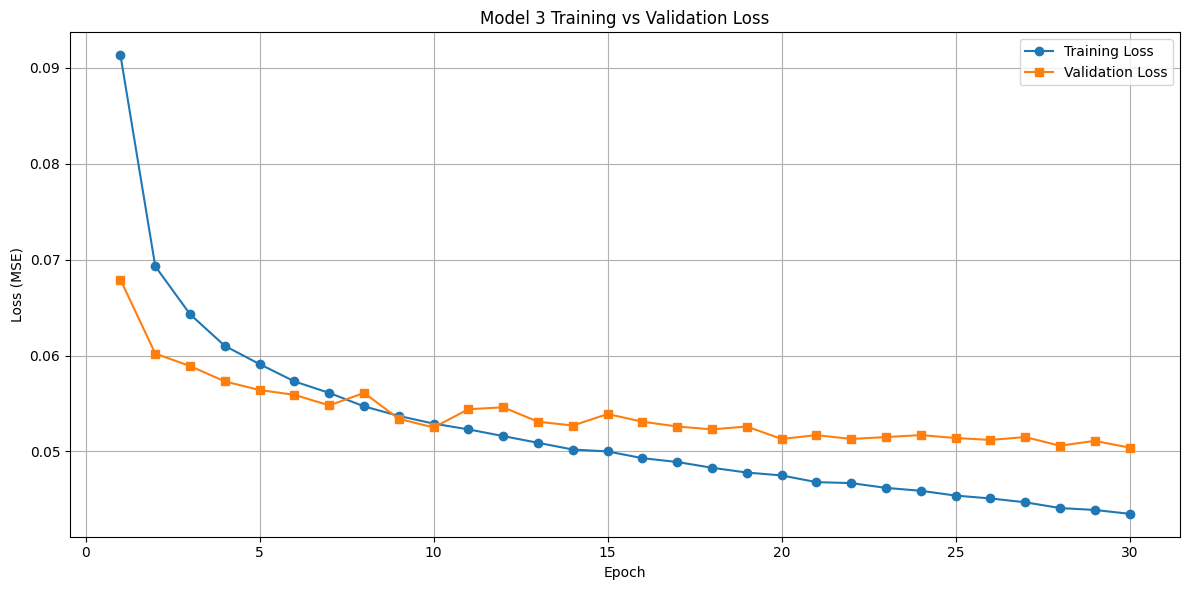

In [1]:
import matplotlib.pyplot as plt

# Model 3: Dual-output branched model training/validation loss
train_losses = [
    0.0913, 0.0693, 0.0643, 0.0610, 0.0591, 0.0573, 0.0561, 0.0547, 0.0537, 0.0529,
    0.0523, 0.0516, 0.0509, 0.0502, 0.0500, 0.0493, 0.0489, 0.0483, 0.0478, 0.0475,
    0.0468, 0.0467, 0.0462, 0.0459, 0.0454, 0.0451, 0.0447, 0.0441, 0.0439, 0.0435
]

val_losses = [
    0.0679, 0.0602, 0.0589, 0.0573, 0.0564, 0.0559, 0.0548, 0.0561, 0.0534, 0.0525,
    0.0544, 0.0546, 0.0531, 0.0527, 0.0539, 0.0531, 0.0526, 0.0523, 0.0526, 0.0513,
    0.0517, 0.0513, 0.0515, 0.0517, 0.0514, 0.0512, 0.0515, 0.0506, 0.0511, 0.0504
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model 3 Training vs Validation Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNNModel3()  # Replace with your actual model class
print(f"Total Trainable Parameters: {count_parameters(model):,}")


Total Trainable Parameters: 373,562
